In [69]:
import pickle
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', -1)
np.random.seed(10)

with open(f"data/label/train_labelled.pkl", 'rb') as fid:
    train = pickle.load(fid)
with open(f"data/label/dev_labelled.pkl", 'rb') as fid:
    dev = pickle.load(fid)
with open(f"data/label/test_labelled.pkl", 'rb') as fid:
    test = pickle.load(fid)

In [70]:
# filter out invalid taggings
train = train[train.term_part_of_speech != 0]
dev = dev[dev.term_part_of_speech != 0]
test = test[test.term_part_of_speech != 0]
train = train[train.term_dep_role != 0]
dev = dev[dev.term_dep_role != 0]
test = test[test.term_dep_role != 0]

# Add in Gold Labels for Evaluation Sets

TODO: Make this cleaner/less error prone.

In [71]:
from ast import literal_eval

# merge round 1 of manual eval
gold_df = pd.read_csv('dev_manual_eval.csv')
gold_df = gold_df[['text', 'term_pair', 'gold_label']]
gold_df.gold_label = gold_df.gold_label.astype(int)
gold_df.term_pair = gold_df.term_pair.apply(literal_eval)
dev = dev.merge(gold_df, how='left', on=['text', 'term_pair'])
dev['gold_label'] = dev.gold_label.fillna(0).astype(int)

# update gold labels with round 2
#gold_df = pd.read_csv('manual_eval2.csv')
#gold_df = gold_df[['text', 'term_pair', 'gold_label']]
#gold_df.gold_label = gold_df.gold_label.astype(int)
#gold_df.term_pair = gold_df.term_pair.apply(literal_eval)
#gold_lookup = {(x.text, x.term_pair): x.gold_label for _, x in gold_df.iterrows()}
#def gold_replace(x):
#    if (x.text, x.term_pair) in gold_lookup:
#        return gold_lookup[x.text, x.term_pair]
#    else:
#        return x.gold_label
#dev.gold_label = dev.apply(gold_replace, axis=1)

test['gold_label'] = test.majority_vote.replace(-1, 0)

# Standardize Label Columns

## Hard Labels

In [72]:
# Option 1 use majority vote across label functions
train['hard_label'] = train.majority_vote 
# Option 2 use most likely class from label model 
#train['no_vote'] = train.label_model_labels.apply(lambda x: min(x) == max(x))
#train['lm_vote'] = train.label_model_labels.apply(np.argmax)
#train.loc[train.no_vote, 'lm_vote'] = -1
#train['hard_label'] = train['lm_vote']

# use hand labelled gold labels for dev and test
dev['hard_label'] = dev.gold_label
test['hard_label'] = test.gold_label

## Soft Labels

In [73]:
#label_fns = [
#    'isa_pattern', 
#    'suchas_pattern',
#    'including_pattern',
#    'called_pattern',
#    'especially_pattern',
#    'appo_pattern', 
#    'other_pattern', 
#    'knownas_pattern', 
#    'term_pos', 
#    'term_modifier',
#    'term_subset',
#    'kb_bio101_ds_pos',
#    'kb_bio101_ds_neg',
#]
#
#    
#def fix_neg(x):
#    if max([x[l] for l in label_fns]) == 0:
#        return (.95, .025, .025)
#    else:
#        return x['label_model_labels']
#train['label_model_labels'] = train.apply(fix_neg, axis=1)

In [74]:
train['soft_label'] = train.label_model_labels
dev['soft_label'] = dev.label_model_labels
test['soft_label'] = test.label_model_labels

## Add Class Labels

# Data Label Distributions 

Majority vote distributions across all sentence, term pair instance for the different classes. For all three:

- non-labelled data is about 15-20%
- hypernyms and hyponyms are relatively equal at about .6-.8%
- negatives are about 80%

In [75]:
train \
    .groupby('hard_label') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,hard_label,count,prop
0,-1,39711,0.232867
1,0,127276,0.746351
2,1,1667,0.009775
3,2,1877,0.011007


In [76]:
dev \
    .groupby('hard_label') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,hard_label,count,prop
0,0,4223,0.966804
1,1,84,0.019231
2,2,61,0.013965


In [77]:
test \
    .groupby('hard_label') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,hard_label,count,prop
0,0,1931,0.974268
1,1,28,0.014127
2,2,23,0.011604


# Exclude Points without labels 

In [78]:
# filter out data points without any labels
train = train[train.hard_label >= 0]

In [79]:
train \
    .groupby('hard_label') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,hard_label,count,prop
0,0,127276,0.972909
1,1,1667,0.012743
2,2,1877,0.014348


# Unique Term Pair Distributions

The above distributions over count term pairs that show up more frequently. Here we first look at unique term pair label distributions. We see that the number of unique term pairs is about 40% less than overall term pairs and the relative proportions are still quite similar.

In [80]:
train \
    .groupby('hard_label') \
    .term_pair \
    .agg(nunique='nunique') \
    .reset_index() \
    .assign(prop=lambda df: df['nunique'] / df['nunique'].sum())

,hard_label,nunique,prop
0,0,76589,0.971547
1,1,1135,0.014398
2,2,1108,0.014055


In [81]:
dev \
    .groupby('hard_label') \
    .term_pair \
    .agg(nunique='nunique') \
    .reset_index() \
    .assign(prop=lambda df: df['nunique'] / df['nunique'].sum())

,hard_label,nunique,prop
0,0,3294,0.964286
1,1,69,0.020199
2,2,53,0.015515


In [82]:
test \
    .groupby('hard_label') \
    .term_pair \
    .agg(nunique='nunique') \
    .reset_index() \
    .assign(prop=lambda df: df['nunique'] / df['nunique'].sum())

,hard_label,nunique,prop
0,0,1641,0.975624
1,1,21,0.012485
2,2,20,0.011891


We can look at distributions of term pair counts to get a sense of this. Most terms have 1 or two occurrences. There are more outliers for no-relation however. Some of these with more occurrences may be problematic and want to be screened (i.e. group and species).

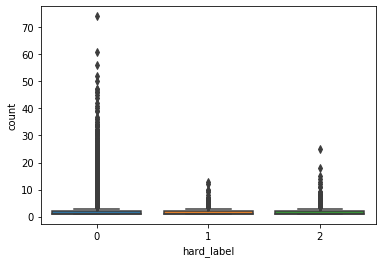

In [83]:
tp_train = \
    train \
    .groupby(['hard_label', 'term_pair']) \
    .term_pair \
    .agg(count='count') \
    .reset_index()
sns.boxplot(data = tp_train, x = 'hard_label', y = 'count')

In [84]:
tp_train[tp_train.hard_label > 0].sort_values('count', ascending=False).head(10)

,hard_label,term_pair,count
78428,2,"(o2, co2)",25
78470,2,"(permeability, membrane)",18
77777,2,"(artery, arteriole)",15
78103,2,"(fat, oil)",14
78176,2,"(gene, allele)",13
76786,1,"(co2, o2)",13
76748,1,"(cell membrane, membrane)",12
78325,2,"(macromolecule, protein)",12
78544,2,"(protein, glycoprotein)",11
78550,2,"(protein, receptor)",11


# Sentence Distributions

The other piece of our input data is sentences. Our data has many term pairs for each sentence so first we can look at how many sentences are in each split.

In [85]:
len(train.groupby('text'))

28268

In [86]:
len(dev.groupby('text'))

753

In [87]:
len(test.groupby('text'))

357

Next we can see how many of these sentences have a positive label in them. 

In [88]:
train \
    .groupby('text') \
    .hard_label \
    .agg(hyponym=lambda x: any(x == 1), hypernym=lambda x: any(x == 2)) \
    .reset_index() \
    .groupby(['hyponym', 'hypernym']) \
    .text \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,hyponym,hypernym,count,prop
0,False,False,25394,0.898330
1,False,True,1361,0.048146
2,True,False,1372,0.048535
3,True,True,141,0.004988


In [89]:
dev \
    .groupby('text') \
    .hard_label \
    .agg(hyponym=lambda x: any(x == 1), hypernym=lambda x: any(x == 2)) \
    .reset_index() \
    .groupby(['hyponym', 'hypernym']) \
    .text \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,hyponym,hypernym,count,prop
0,False,False,643,0.853918
1,False,True,42,0.055777
2,True,False,62,0.082337
3,True,True,6,0.007968


In [90]:
test \
    .groupby('text') \
    .hard_label \
    .agg(hyponym=lambda x: any(x == 1), hypernym=lambda x: any(x == 2)) \
    .reset_index() \
    .groupby(['hyponym', 'hypernym']) \
    .text \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,hyponym,hypernym,count,prop
0,False,False,317,0.887955
1,False,True,16,0.044818
2,True,False,23,0.064426
3,True,True,1,0.002801


Finally we can look at the distribution of total term pair counts within individual sentences.

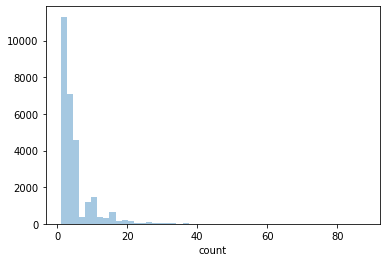

In [91]:
tmp = \
    train \
    .groupby('text') \
    .term_pair \
    .agg(count='count') \
    .reset_index() \
    .sort_values('count', ascending=False)
sns.distplot(tmp['count'], norm_hist=False, kde=False)

# Down Sample Training Data

Currently the training data has over 100,000 examples with only about 1 percent positive examples. To make this more tractable and balanced we sample down both negatives sentences without a taxonomic relationship and then sample down negative examples within sentences 

In [92]:
# sample down negative sentences
sent_check = train.groupby('text').agg({'majority_vote': lambda x: sum(x) > 0}).reset_index()
neg_exs = sent_check[~sent_check.majority_vote].sample(frac=0.50)
print(train.shape)
train_reduced = train[~train.text.isin(neg_exs.text)]
train_reduced.shape

(130820, 30)


(75665, 30)

In [93]:
# sample down negative examples within sentences
sent_check = train_reduced.groupby(['text', 'term_pair']).agg({'majority_vote': lambda x: sum(x) > 0}).reset_index()
neg_exs = sent_check[~sent_check.majority_vote].sample(frac=0.6)
neg_exs['part'] = list(zip(neg_exs['text'], neg_exs['term_pair']))
train_reduced['part'] = list(zip(train_reduced['text'], train_reduced['term_pair']))
train_reduced = train_reduced[~train_reduced.part.isin(neg_exs.part)]
train_reduced.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(32388, 31)

In [94]:
train_reduced \
    .groupby('hard_label') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,hard_label,count,prop
0,0,28844,0.890577
1,1,1667,0.051470
2,2,1877,0.057954


In [95]:
train_reduced \
    .groupby('hard_label') \
    .term_pair \
    .agg(nunique='nunique') \
    .reset_index() \
    .assign(prop=lambda df: df['nunique'] / df['nunique'].sum())

,hard_label,nunique,prop
0,0,23641,0.913344
1,1,1135,0.043849
2,2,1108,0.042806


In [96]:
print(len(np.unique(train_reduced.text)))

11740


In [97]:
train_reduced \
    .groupby('text') \
    .hard_label \
    .agg(hyponym=lambda x: any(x == 1), hypernym=lambda x: any(x == 2)) \
    .reset_index() \
    .groupby(['hyponym', 'hypernym']) \
    .text \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,hyponym,hypernym,count,prop
0,False,False,8866,0.755196
1,False,True,1361,0.115928
2,True,False,1372,0.116865
3,True,True,141,0.012010


# Create a small debugging set

In [98]:
# create a debugging set with 10 sentences with a taxonomy relation and 10 without
sent_check = train.groupby('text').agg({'hard_label': lambda x: sum(x) > 0}).reset_index()
pos_exs = sent_check[sent_check.hard_label].sample(5)
neg_exs = sent_check[~sent_check.hard_label].sample(5)
debug = pd.concat(
    [train[train.text.isin(pos_exs.text)], 
     train[train.text.isin(neg_exs.text)]], 
    axis=0)
debug.shape

(58, 30)

# Write out data

In [99]:
train.to_pickle('data/model_data/train_full.pkl')
train_reduced.to_pickle('data/model_data/train.pkl')
debug.to_pickle('data/model_data/debug.pkl')
dev.to_pickle('data/model_data/dev.pkl')
test.to_pickle('data/model_data/test.pkl')